In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy
from scipy.integrate import odeint

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Kuramoto model
$$ \dot \varphi_i = \omega_i + \frac K N \sum_{j=1}^N{a_{ij}}\sin(\varphi_j - \varphi_i)$$

In [2]:
#define all needed variables
N = 10
# phi = np.zeros(N)
omega = np.random.uniform(low=-1, high=1, size=(N**2))
# omega = omega**3 - 0.3*omega
K = 80

def make_A(N=10):
    #make an adjaceny matrix for an NxN systems where neighbors are connected. 
    #periodic boundary conditions
    
    #this is super messy, maybe make clearer. 
    
    
    A = np.zeros((N**2,N**2))
    #handle corners
    #top left
    A[0,1] = 1
    A[0,N-1] = 1
    A[0,N] = 1
    A[0, N**2 - N] = 1
    #bottom left
    A[N-1,0] = 1
    A[N-1,N-2] = 1
    A[N-1,N**2 - 1] = 1
    A[N-1, 2*N-1] = 1
#     top right
    A[ N**2 - N,  N**2 - N+1] = 1
    A[ N**2 - N, N**2 - 1] = 1
    A[ N**2 - N, 0] = 1
    A[ N**2 - N,  N**2 - 2*N] = 1
    #bottom right
    A[ N**2 - 1,  N**2 - N] = 1
    A[ N**2 - 1, N**2 - 2] = 1
    A[ N**2 - 1, N**2 - N-1] = 1
    A[ N**2 - 1,  N-1] = 1
    
    #first column
    for i in range(1, N-1):
        A[i, i + N] = 1
        A[i, N**2 - N + i] = 1
        A[i, i + 1] = 1
        A[i, i - 1] = 1
    #first column
    for i in range(1, N-1):
        A[N**2 - N + i, N**2 - N + i+1] = 1
        A[N**2 - N + i, N**2 - N + i-1] = 1
        A[N**2 - N + i, N**2 - 2*N + i] = 1
        A[N**2 - N + i, i] =1
    #first row
    for i in range(1, N-1):
        A[i*N, (i-1)*N] = 1
        A[i*N, (i+1)*N] = 1
        A[i*N, i*N + 1] = 1
        A[i*N, (i+1)*N - 1] = 1
    #last row
    for i in range(2, N):
        A[i*N-1, i*N-2] = 1
        A[i*N-1, i*N-N] = 1
        A[i*N-1, (i-1)*N-1] = 1
        A[i*N-1, (i+1)*N-1] = 1
    #middles
    for i in range(N+1, N**2-N-1):
        if(i%N != N-1) and (i%N != 0):
            A[i, i+1] = 1
            A[i, i-1] = 1
            A[i, i-N] = 1
            A[i, i+N] = 1
    return A

# A = np.ones((N,N)) - np.eye(N) #this is all to all right now, but want to make it so you can set the number of connections
A = make_A(N)
# print(np.sum(A)/((N**2-1)**2))
# plt.figure()
# plt.imshow(A)
dt = 0.01 #timestep size, if this is too large, weird things seem to be happening
T_max = 40. #maximum time to run simulation for
t = np.arange(0, T_max, dt)
# print(t.shape)

In [3]:
def phi_dot(phi, t, omega, K, A):
    #this is for the Kuramoto oscillator
    N = len(phi)
    dphi_dt = np.zeros(np.shape(phi))
    for i in range(N):
        dphi_dt[i] = (omega[i] + K/N *np.sum(A[i]@np.sin(phi - phi[i])))
    return dphi_dt

In [4]:
#do the integration part
start = np.random.uniform(0,1,size = (N**2))
sol1 = odeint(phi_dot, start, t, args=(omega, K, A))
sol2 = odeint(phi_dot, start, t, args=(omega, K*2, A))
sol4 = odeint(phi_dot, start, t, args=(omega, K*4, A))
sol8 = odeint(phi_dot, start, t, args=(omega, K*8, A))
sol16 = odeint(phi_dot, start, t, args=(omega, K*16, A))

-0.7825561875490428
0.005634895200844387


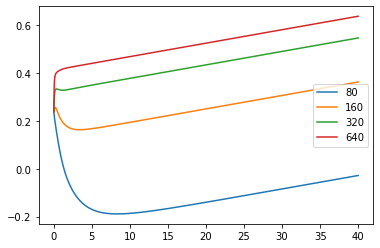

In [5]:
%matplotlib inline
i = 25
plt.plot(t, sol1[:,i], label = K)
plt.plot(t, sol2[:,i], label = 2*K)
plt.plot(t, sol4[:,i], label = 4*K)
plt.plot(t, sol8[:,i], label = 8*K)
print(omega[i])
print(np.mean(omega))
plt.legend()

# plt.plot(t, omega[i]*t + sol1[0,i], 'black')
# plt.plot(t, np.mean(omega)*t + sol1[0,i], 'black')
plt.show()

-0.7825561875490428
0.005634895200844387


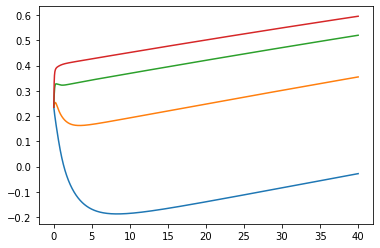

In [6]:
%matplotlib inline
i = 25
plt.plot(t, np.sin(sol1[:,i]))
plt.plot(t, np.sin(sol2[:,i]))
plt.plot(t, np.sin(sol4[:,i]))
plt.plot(t, np.sin(sol8[:,i]))
print(omega[i])
print(np.mean(omega))

# plt.plot(t, omega[i]*t + sol1[0,i], 'black')
# plt.plot(t, np.mean(omega)*t + sol1[0,i], 'black')
plt.show()

In [48]:
#making autoencoder


class Net(nn.Module):
    def __init__(self, N, n_hidden, n_important):
        super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(N**2, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_important)
        self.fc3 = nn.Linear(n_important, n_hidden)
        self.fc4 = nn.Linear(n_hidden, N**2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

n_hidden = np.int(np.sqrt(N**2))
n_important = 3
net = Net(N, n_hidden, n_important)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)\


n_iter = 10000
min_error = 4e-4
inputs = torch.from_numpy(sol1).float()
for epoch in range(n_iter):  # loop over the dataset multiple times

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        if(loss < min_error):
            break
        if epoch % int(n_iter/100) == 0:
            print(epoch)
            print(loss)

print('Finished Training')


0
tensor(0.5959, grad_fn=<MseLossBackward>)
100
tensor(0.2729, grad_fn=<MseLossBackward>)
200
tensor(0.0092, grad_fn=<MseLossBackward>)
300
tensor(0.0061, grad_fn=<MseLossBackward>)
400
tensor(0.0059, grad_fn=<MseLossBackward>)
500
tensor(0.0057, grad_fn=<MseLossBackward>)
600
tensor(0.0056, grad_fn=<MseLossBackward>)
700
tensor(0.0055, grad_fn=<MseLossBackward>)
800
tensor(0.0053, grad_fn=<MseLossBackward>)
900
tensor(0.0053, grad_fn=<MseLossBackward>)
1000
tensor(0.0052, grad_fn=<MseLossBackward>)
1100
tensor(0.0051, grad_fn=<MseLossBackward>)
1200
tensor(0.0050, grad_fn=<MseLossBackward>)
1300
tensor(0.0050, grad_fn=<MseLossBackward>)
1400
tensor(0.0049, grad_fn=<MseLossBackward>)
1500
tensor(0.0048, grad_fn=<MseLossBackward>)
1600
tensor(0.0048, grad_fn=<MseLossBackward>)
1700
tensor(0.0047, grad_fn=<MseLossBackward>)
1800
tensor(0.0047, grad_fn=<MseLossBackward>)
1900
tensor(0.0046, grad_fn=<MseLossBackward>)
2000
tensor(0.0046, grad_fn=<MseLossBackward>)
2100
tensor(0.0046, grad_

In [44]:
print(sol1.shape)

(4000, 100)


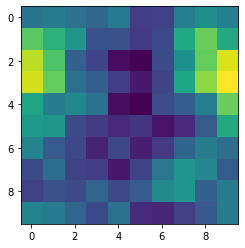

MSE of 1 =  0.0005079799801649939


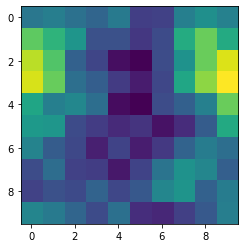

In [53]:
i = 2000
predicted = net(inputs[i,:])
pred_np = predicted.detach().numpy()
plt.imshow(pred_np.reshape(N,N))
plt.show()
plt.imshow(sol1[i,:].reshape(N,N))
print("MSE of 1 = ", ((pred_np - sol1[i,:])**2).mean())

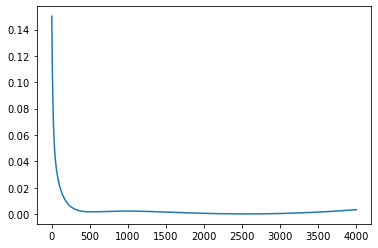

In [62]:
plt.plot(((net(inputs).detach().numpy() - sol1)**2).mean(axis=1))

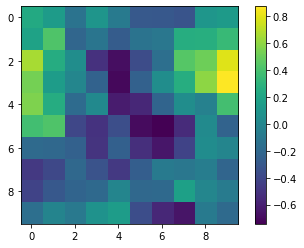

In [46]:
plt.imshow((pred_np - sol1[i,:]).reshape(N,N))
plt.colorbar()